In [1]:
pip install simpy

**Peliculas/Cine**

Tipicos:
- Recursos
- Condiciónd de evnetos
- Eventos compartidos

**Enunciado**:

Modelar una sala de cine  con un mostrador para la venta de entradas a tres tipos de peliculas diferentes, tener en cuenta que se modela solo para un espectáculo.
- Las personas llegan en momentos aleatorios e intentan comprar un numero aleatorio de boletos (1-6) para una pelicula al azar.

- Cuando se agota las entradas a una pelicula, las personas que esperan por un boleto salen de la cola.

- La sala de cine es un Contenedor que abarca todos los procesos.
- El mostrador es un Recurso con la capacidad de uno.
- Finalmente, si la ultima persona desea comprar más boletos de los existentes se le vende solo los que tiene el mostrador.


In [20]:
import collections
import random
import simpy

NUM_BOLETO = 50
TIEMPO_SIMULACION = 120

def ventaBoletos(env, num_boletos, pelicula, teatro):
  with teatro.contador.request() as turno:
    resultado = yield turno | teatro.sold_out[pelicula]
    if turno not in resultado:
      teatro.num_renegados[pelicula] += 1
      return
    if teatro.num_boletos[pelicula] < num_boletos:
      yield env.timeout(0.5) 
      return
    teatro.num_boletos[pelicula] -= num_boletos
    if teatro.num_boletos[pelicula] < 2:
      teatro.sold_out[pelicula].succeed()
      teatro.tiempo_agotado[pelicula] = env.now
      teatro.num_boletos[pelicula] = 0
    yield env.timeout(1)


def llegadaClientes(env, teatro):
  while True:
    yield env.timeout(random.expovariate(1/0.5))
    pelicula = random.choice(teatro.peliculas)
    num_boletos = random.randint(1, 6)
    if teatro.num_boletos[pelicula]:
      env.process(ventaBoletos(env, num_boletos, pelicula, teatro))


Teatro = collections.namedtuple('Teatro', 'contador, peliculas, num_boletos, sold_out, tiempo_agotado, num_renegados')

print('Teatro Carlos Crespi - UPS')
env = simpy.Environment()

contador = simpy.Resource(env,capacity=1)
peliculas = ['Conjuro 3', 'Rapidos y Furiosos 10', 'Pulp Fictions']
num_boletos = {pelicula: NUM_BOLETO for pelicula in peliculas}
sold_out = {pelicula: env.event() for pelicula in peliculas}
tiempo_agotado = {pelicula: None for pelicula in peliculas}
num_renegados = {pelicula: 0 for pelicula in peliculas}

teatro = Teatro(contador, peliculas, num_boletos, sold_out, tiempo_agotado, num_renegados)
env.process(llegadaClientes(env, teatro))
env.run(until=TIEMPO_SIMULACION)

# Analisis y resultados
for pelicula in peliculas:
  if teatro.sold_out[pelicula]:
    print('Pelicula: %s se agoto en el tiempo %.1f despues de salir a la venta' %(pelicula, teatro.tiempo_agotado[pelicula]))
    print('Numero de personas que salieron de la fila/renegados %s' %teatro.num_renegados[pelicula])


Teatro Carlos Crespi - UPS
Pelicula: Conjuro 3 se agoto en el tiempo 38.4 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 14
Pelicula: Rapidos y Furiosos 10 se agoto en el tiempo 26.9 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 8
Pelicula: Pulp Fictions se agoto en el tiempo 37.4 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 18


Modificamos para agregar probabilidad a las peliculas al momento de comprar un boleto

Teatro Carlos Crespi - UPS
Pelicula: Conjuro 3 se agoto en el tiempo 39.7 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 8
Pelicula: Rapidos y Furiosos 10 se agoto en el tiempo 22.2 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 3
Pelicula: Pulp Fictions se agoto en el tiempo 50.1 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 0


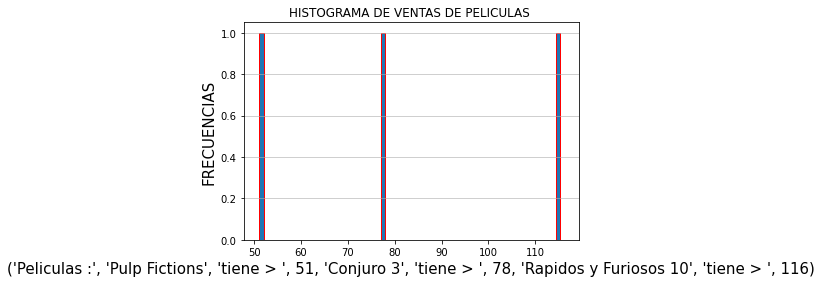

In [41]:
import collections
import random
import simpy
import matplotlib.pyplot as plt
VELOCIDAD_LLEGADA = 42
NUM_BOLETO = 50
TIEMPO_SIMULACION = 120

veces_pelicula_vista = [0,0,0]
def ventaBoletos(env, num_boletos, pelicula, teatro):
  with teatro.contador.request() as turno:
    resultado = yield turno | teatro.sold_out[pelicula]
    if turno not in resultado:
      teatro.num_renegados[pelicula] += 1
      return
    if teatro.num_boletos[pelicula] < num_boletos:
      yield env.timeout(0.5) 
      return
    teatro.num_boletos[pelicula] -= num_boletos
    if teatro.num_boletos[pelicula] < 2:
      teatro.sold_out[pelicula].succeed()
      teatro.tiempo_agotado[pelicula] = env.now
      teatro.num_boletos[pelicula] = 0
    yield env.timeout(1)


def llegadaClientes(env, teatro):
  while True:
    yield env.timeout(random.expovariate(1/0.5))
    pelicula = random.choices(teatro.peliculas, teatro.probabilidad, k=1)
    #SE OBTIENE DATOS PARA LA GRAFICA
    if pelicula[0] == peliculas[0]:
        veces_pelicula_vista[0] +=1
    elif pelicula[0]== peliculas[1]:
        veces_pelicula_vista[1] +=1
    elif pelicula[0] == peliculas[2]:
        veces_pelicula_vista[2] +=1
    
    num_boletos = random.randint(1, 6)
    if teatro.num_boletos[pelicula[0]]:
      env.process(ventaBoletos(env, num_boletos, pelicula[0], teatro))


Teatro = collections.namedtuple('Teatro', 'contador, peliculas, probabilidad, num_boletos, sold_out, tiempo_agotado, num_renegados')

print('Teatro Carlos Crespi - UPS')
env = simpy.Environment()
contador = simpy.Resource(env,capacity=1)
peliculas = ['Conjuro 3', 'Rapidos y Furiosos 10', 'Pulp Fictions']
probabilidad=[0.2, 0.3, 0.1]
num_boletos = {pelicula: NUM_BOLETO for pelicula in peliculas}
sold_out = {pelicula: env.event() for pelicula in peliculas}
tiempo_agotado = {pelicula: None for pelicula in peliculas}
num_renegados = {pelicula: 0 for pelicula in peliculas}

teatro = Teatro(contador, peliculas, probabilidad, num_boletos, sold_out, tiempo_agotado, num_renegados)
env.process(llegadaClientes(env, teatro))
env.run(until=TIEMPO_SIMULACION) 
# Analisis y resultados
for pelicula in peliculas:
  if teatro.sold_out[pelicula]:
    print('Pelicula: %s se agoto en el tiempo %.1f despues de salir a la venta' %(pelicula, teatro.tiempo_agotado[pelicula]))
    print('Numero de personas que salieron de la fila/renegados %s' %teatro.num_renegados[pelicula])

    
#SE GRAFICA EL HISTOGRAMA
plt.title('HISTOGRAMA DE VENTAS DE PELICULAS ')
plt.hist(veces_pelicula_vista,bins=40,width=1,alpha = 1, edgecolor = 'red')
plt.grid(axis='y',alpha = 0.75)
s = "Peliculas :",peliculas[2],"tiene > ",veces_pelicula_vista[2],peliculas[0],"tiene > ",veces_pelicula_vista[0],peliculas[1],"tiene > ",veces_pelicula_vista[1]
plt.xlabel(s,fontsize = 15)
plt.ylabel('FRECUENCIAS',fontsize = 15)
plt.show()

In [2]:
#SE GRAFICA LA SIMULACION DE TEATRO
import pygame, sys
pygame.init()

#SE DEFINE LOS COLORES
BLACK = (0,0,0)
WHITE = (255,255,255)
GREEN = (0,255,0)
RED = (255,0,0)
BLUE = (0,0,255)
size=(800,500)
screen = pygame.display.set_mode(size)
screen.fill(WHITE)

for x in range(100,700,100):
    pygame.draw.rect(screen,BLACK,(x,230,50,50))
    pygame.draw.line(screen,GREEN,(x,0),(x,100),5)
pygame.display.flip()

**Tarea/Practica**

Al modelo de simulación de la venta de boletos de un teatro/cine agregar la simulación grafica 2D/3D utilizando cualquier libreria grafica, por ejemplo pygame/tkinter, etc. generar un informe en formato PDF que me permita evidenciar la simulación y generar una grafica/reporte de los resultados.